# 6.5 超参数的验证

从MNIST中获得验证数据

(x_train, t_train), (x_test, t_test) = load_mnist()

# 打乱数据
x_train, t_train = shuffle_dataset(x_train, t_train)

# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

## 6.5.3 超参数最优化的实现

val acc:0.08 | lr:5.044417730207821e-06, weight decay:9.229541048136903e-05
val acc:0.08 | lr:2.1310898447085153e-05, weight decay:1.8478216138895977e-05
val acc:0.07 | lr:8.151419632364639e-05, weight decay:4.4179695397221535e-05
val acc:0.13 | lr:1.3012393771948537e-05, weight decay:8.537983673590766e-06
val acc:0.15 | lr:1.6476914551658926e-06, weight decay:2.7239146240816845e-06
val acc:0.11 | lr:1.5524280918867296e-05, weight decay:1.1713437920373326e-07
val acc:0.68 | lr:0.004671315674748829, weight decay:4.299285523644029e-08
val acc:0.16 | lr:7.004271845601314e-05, weight decay:6.385031898165426e-05
val acc:0.18 | lr:0.00041436078988582706, weight decay:1.2076955420952316e-08
val acc:0.08 | lr:0.00021042614977284698, weight decay:5.2550996198271475e-06
val acc:0.15 | lr:0.00021735623989434987, weight decay:3.5554897674685354e-06
val acc:0.11 | lr:0.00029318686879047654, weight decay:1.5806467691326715e-06
val acc:0.12 | lr:5.303716313257874e-06, weight decay:8.495403812845781e-

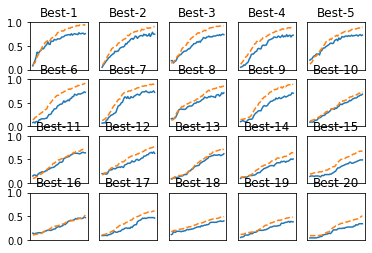

In [2]:
# ch06/hyperparameter_optimization.py
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了实现高速化，减少训练数据
x_train = x_train[:500]
t_train = t_train[:500]

# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 超参数的随机搜索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 指定搜索的超参数的范围===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 绘制图形========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()